In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
# 读取相关数据
save_dir = 'drive/MyDrive/Colab Notebooks/data_512/'

train_images = np.load(os.path.join(save_dir, 'train_images.npy'))
train_masks = np.load(os.path.join(save_dir, 'train_masks.npy'))
valid_images = np.load(os.path.join(save_dir, 'valid_images.npy'))
valid_masks = np.load(os.path.join(save_dir, 'valid_masks.npy'))

# 定义 VGG16 + FCN 模型
def build_fcn_model():
    # 使用 VGG16 作为特征提取器
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

    # 冻结所有层
    for layer in vgg_base.layers:
        layer.trainable = False

    # 获取 VGG16 的输出
    x = vgg_base.output

    # 添加分割头 (多层上采样 + 卷积)
    x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = UpSampling2D(size=(2, 2))(x)  # 上采样到 512x512
    x = Conv2D(4, (1, 1), activation='softmax')(x)  # 最终输出与类别数一致，3类+背景

    # 创建模型
    model = Model(inputs=vgg_base.input, outputs=x)
    return model

# 构建并编译模型
model = build_fcn_model()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 训练模型并保存
model.fit(train_images, train_masks, epochs=50, batch_size=16, validation_data=(valid_images, valid_masks))
model.save('drive/MyDrive/Colab Notebooks/VGG16_FCN_model.keras')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 73s 240ms/step - accuracy: 0.8456 - loss: 0.4024 - val_accuracy: 0.9514 - val_loss: 0.1291
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.9599 - loss: 0.1112 - val_accuracy: 0.9707 - val_loss: 0.1021
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.9756 - loss: 0.0716 - val_accuracy: 0.9750 - val_loss: 0.0746
Epoch 4/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.9811 - loss: 0.0529 - val_accuracy: 0.9763 - val_loss: 0.0770
Epoch 5/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.9838 - loss: 0.0444 - val_accuracy: 0.9767 - val_loss: 0.0727
Epoch 6/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.9865 - loss: 0.0364 - val_accuracy: 0.9772 - val_loss: 0.0813
Epoch 7/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.9879 - loss: 0.0323 - val_accuracy: 0.9772 - val_loss: 0.0807
Epoch 8/50
199/199 ━━━━━━━━━━━━━━━━━━━

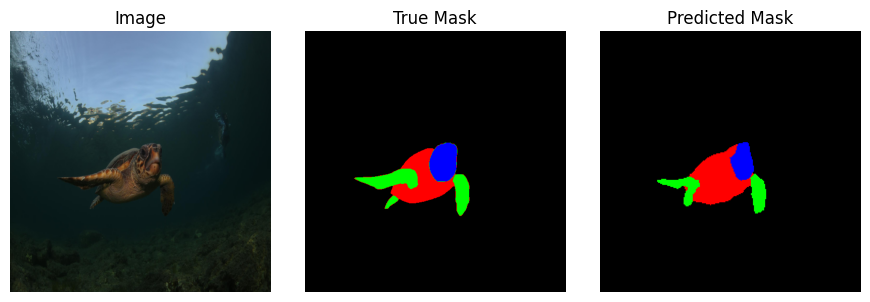


Image 1:	
Class 1 IoU: 0.5932	Class 2 IoU: 0.4763	Class 3 IoU: 0.6332	

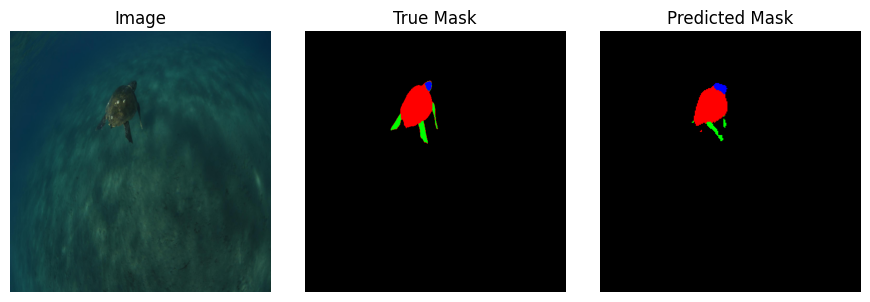


Image 2:	
Class 1 IoU: 0.8058	Class 2 IoU: 0.1336	Class 3 IoU: 0.2530	

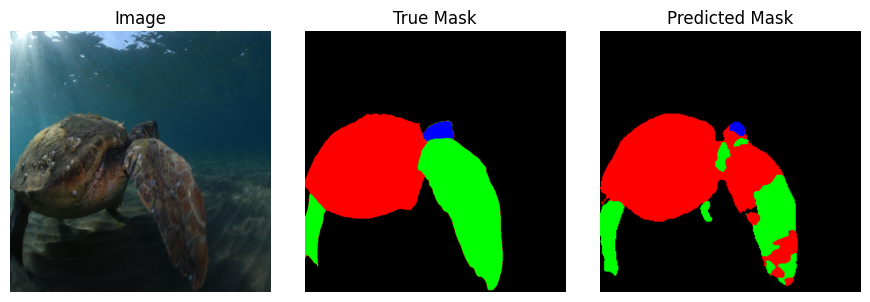


Image 3:	
Class 1 IoU: 0.6812	Class 2 IoU: 0.4577	Class 3 IoU: 0.3580	

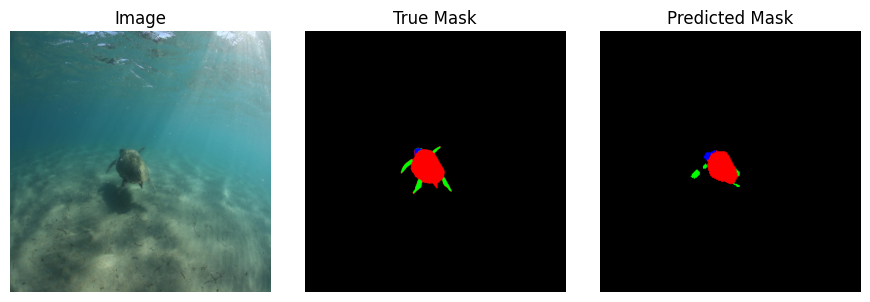


Image 4:	
Class 1 IoU: 0.8026	Class 2 IoU: 0.0324	Class 3 IoU: 0.1057	

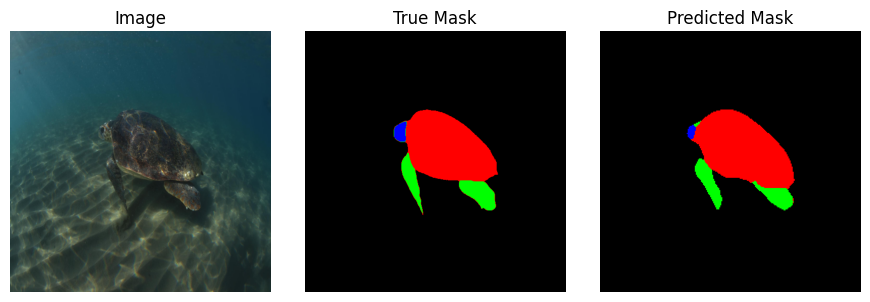


Image 5:	
Class 1 IoU: 0.8838	Class 2 IoU: 0.6230	Class 3 IoU: 0.3309	

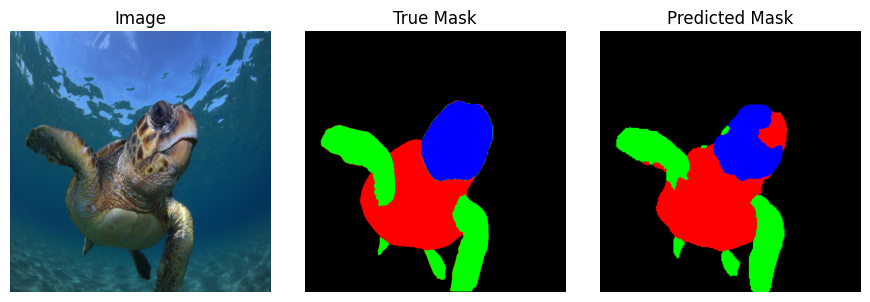


Image 6:	
Class 1 IoU: 0.7517	Class 2 IoU: 0.7730	Class 3 IoU: 0.7505	

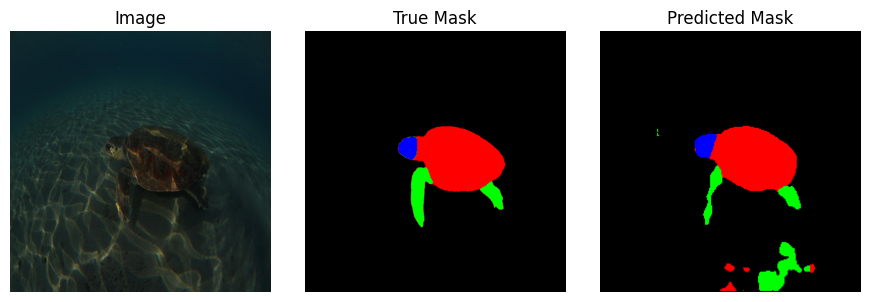


Image 7:	
Class 1 IoU: 0.8731	Class 2 IoU: 0.2730	Class 3 IoU: 0.7217	

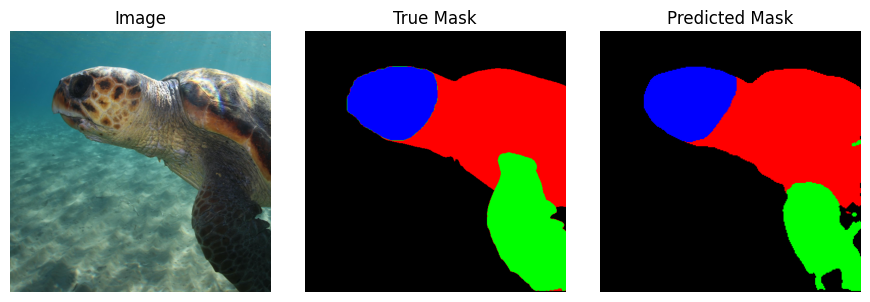


Image 8:	
Class 1 IoU: 0.8747	Class 2 IoU: 0.7009	Class 3 IoU: 0.9417	

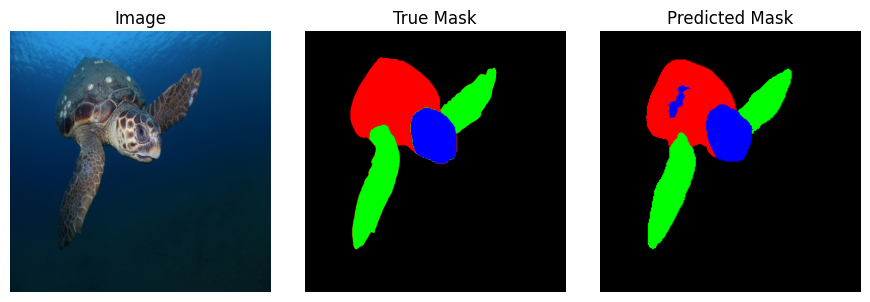


Image 9:	
Class 1 IoU: 0.8119	Class 2 IoU: 0.8652	Class 3 IoU: 0.7805	

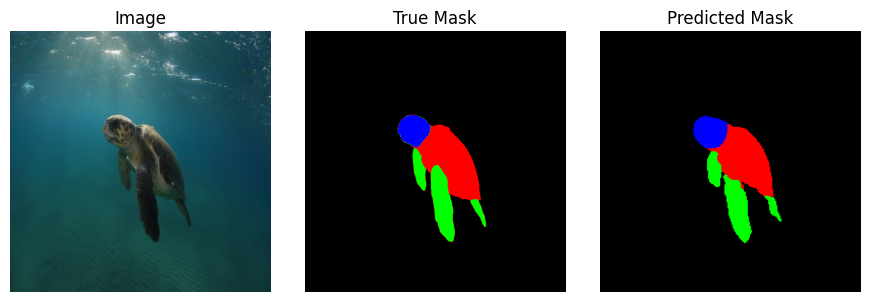


Image 10:	
Class 1 IoU: 0.7565	Class 2 IoU: 0.7185	Class 3 IoU: 0.8030	

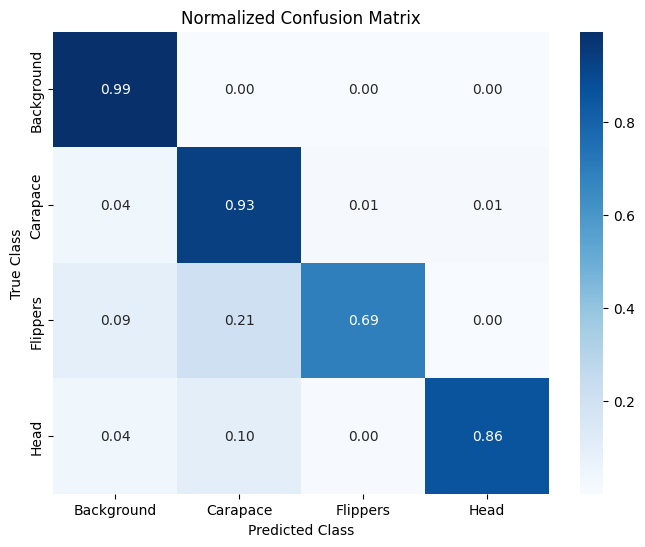

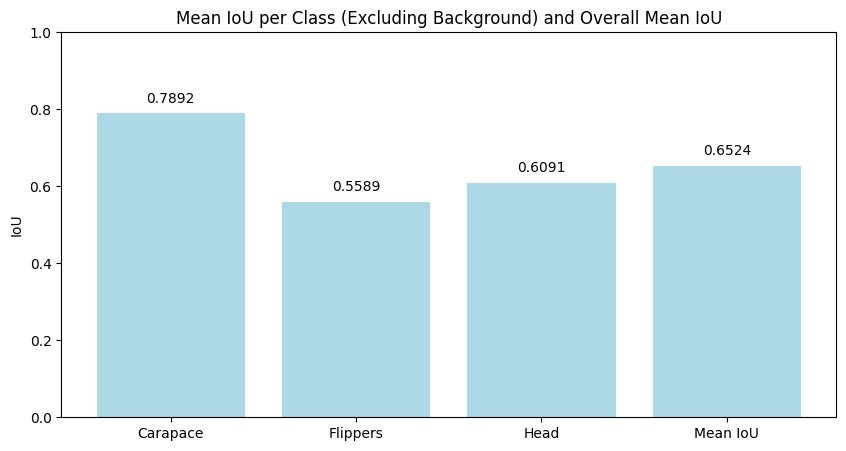


Mean IoU per Class:
Carapace: 0.7892
Flippers: 0.5589
Head: 0.6091
Overall Mean IoU: 0.6524


In [6]:
# 读取相关数据与模型
save_dir = 'drive/MyDrive/Colab Notebooks/data_512/'
test_images = np.load(os.path.join(save_dir, 'test_images.npy'))
test_masks = np.load(os.path.join(save_dir, 'test_masks.npy'))
model = tf.keras.models.load_model('drive/MyDrive/Colab Notebooks/VGG16_FCN_model.keras')

# 可视化预测结果
def visualize_fcn_results(image, mask_true, mask_pred):
    # NumPy数组转换为PIL Image对象
    image = Image.fromarray(image.astype(np.uint8)).resize((512, 512))

    # 创建彩色掩码
    mask_true_colored = np.zeros((512, 512, 3), dtype=np.uint8)
    mask_pred_colored = np.zeros((512, 512, 3), dtype=np.uint8)

    # 颜色字典，每个类别分配一个不同的颜色
    colors = {
        0: (0, 0, 0),       # 背景，黑色
        1: (255, 0, 0),     # 类别1，红色
        2: (0, 255, 0),     # 类别2，绿色
        3: (0, 0, 255),     # 类别3，蓝色
    }

    # 为每个类别分配颜色
    mask_true = mask_true.reshape((512, 512))
    mask_pred = np.argmax(mask_pred, axis=-1).reshape((512, 512))

    for class_id, color in colors.items():
        mask_true_colored[mask_true == class_id] = color
        mask_pred_colored[mask_pred == class_id] = color

    # 可视化
    plt.figure(figsize=(9, 3))
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(mask_true_colored)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(mask_pred_colored)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# 为指定类别计算IoU
def calculate_iou(true_mask, pred_mask, class_id):
    true_class = (true_mask == class_id)
    pred_class = (pred_mask == class_id)
    intersection = np.logical_and(true_class, pred_class).sum()
    union = np.logical_or(true_class, pred_class).sum()

    if union == 0:
        return np.nan
    else:
        return intersection / union

# 计算混淆矩阵
def calculate_confusion_matrix(true_mask, pred_mask, num_classes=4):
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

    for t, p in zip(true_mask.flatten(), pred_mask.flatten()):
        confusion_matrix[t, p] += 1

    return confusion_matrix

# 可视化混淆矩阵
def plot_confusion_matrix(cm, class_names):
    # 计算比例
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # 可视化混淆矩阵
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Normalized Confusion Matrix')
    plt.show()

if len(test_images) > 0 and len(test_masks) > 0:
    num_visualize = 10  # 可视化图像数量
    overall_confusion_matrix = np.zeros((4, 4), dtype=np.int64)  # 初始化整体混淆矩阵
    for i in range(num_visualize):
        sample_image = test_images[i]
        sample_mask = test_masks[i]
        sample_prediction = model.predict(np.expand_dims(sample_image, axis=0), verbose=0)[0]
        visualize_fcn_results(sample_image, sample_mask, sample_prediction)

        # 计算每类的IoU
        pred_mask = np.argmax(sample_prediction, axis=-1).reshape((512, 512))
        true_mask = sample_mask.reshape((512, 512))

        print(f"\nImage {i + 1}:\t")
        for class_id in range(1, 4):  # 从1开始，因为0是背景
            iou = calculate_iou(true_mask, pred_mask, class_id)
            if not np.isnan(iou):
                print(f"Class {class_id} IoU: {iou:.4f}", end = '\t')
            else:
                print(f"Class {class_id} IoU: NaN (no instances in true mask)", end = '\t')

        # 计算并累加到整体混淆矩阵
        confusion_matrix = calculate_confusion_matrix(true_mask, pred_mask, num_classes=4)
        overall_confusion_matrix += confusion_matrix

    # 可视化整体混淆矩阵
    class_names = ['Background', 'Carapace', 'Flippers', 'Head']
    plot_confusion_matrix(overall_confusion_matrix, class_names)

# 计算并打印每个类的mIoU
def evaluate_miou(test_images, test_masks, model, num_classes=4):
    ious_per_class = {i: [] for i in range(1, num_classes)}  # 存储每类的IoU

    for i in range(len(test_images)):
        sample_image = test_images[i]
        sample_mask = test_masks[i]
        sample_prediction = model.predict(np.expand_dims(sample_image, axis=0), verbose=0)[0]
        pred_mask = np.argmax(sample_prediction, axis=-1).reshape((512, 512))
        true_mask = sample_mask.reshape((512, 512))

        # 对每个类别计算IoU
        for class_id in range(1, num_classes):  # 从1开始，因为0是背景
            iou = calculate_iou(true_mask, pred_mask, class_id)
            if not np.isnan(iou):  # 只添加有效的IoU
                ious_per_class[class_id].append(iou)

    # 计算每个类的mIoU
    mean_ious = {}
    for class_id, ious in ious_per_class.items():
        mean_ious[class_id] = np.nanmean(ious) if ious else np.nan  # 忽略NaN

    # 计算并输出整体mIoU
    overall_miou = np.nanmean(list(mean_ious.values()))

    # 可视化mIoU
    class_labels = ['Carapace', 'Flippers', 'Head']
    mean_iou_per_class = [mean_ious[i] for i in range(1, num_classes)]
    plt.figure(figsize=(10, 5))
    bars = plt.bar(class_labels + ['Mean IoU'], mean_iou_per_class + [overall_miou], color='lightblue')
    plt.ylim(0, 1)
    plt.ylabel("IoU")
    plt.title("Mean IoU per Class (Excluding Background) and Overall Mean IoU")

    for bar, value in zip(bars, mean_iou_per_class + [overall_miou]):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{value:.4f}', ha='center', va='bottom')

    plt.show()

    # 输出每个类的mIoU和整体的mIoU
    print("\nMean IoU per Class:")
    for class_label, iou in zip(class_labels, mean_iou_per_class):
        print(f"{class_label}: {iou:.4f}")
    print(f"Overall Mean IoU: {overall_miou:.4f}")

    return mean_ious, overall_miou

# 并计算每类的mIoU
if len(test_images) > 0 and len(test_masks) > 0:
    mean_ious, overall_miou = evaluate_miou(test_images, test_masks, model)